In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
keras = tf.keras

from sklearn.preprocessing import MinMaxScaler

# set style of charts
sns.set(style="darkgrid")

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def seq2seq_window_dataset(series, window_size, batch_size=128,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

def sequential_window_dataset(series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
# Read in data
spy = pd.read_csv('btc_6h.csv')

# Convert series into datetime type
spy['datetime'] = pd.to_datetime(spy['datetime'])

# Save target series
series = spy['close']

# Create train data set
train_split_date = '31-01-2020 05:30:00'
train_split_index = np.where(spy.datetime == train_split_date)[0][0]
x_train = spy.loc[spy['datetime'] <= train_split_date]['close']

# Create test data set
test_split_date = '31-01-2021 05:30:00'
test_split_index = np.where(spy.datetime == test_split_date)[0][0]
x_test = spy.loc[spy['datetime'] >= test_split_date]['close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['datetime'] < test_split_date) & (spy['datetime'] > train_split_date)]['close']

3034 3035 4497 4498 5958


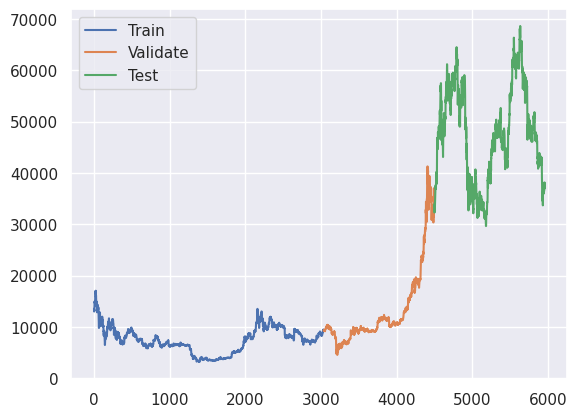

In [ ]:
# Plot all lines on one chart to see where one segment starts and another ends
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [ ]:
# Reshape values
x_train_values = x_train.values.reshape(-1, 1)
x_valid_values = x_valid.values.reshape(-1, 1)
x_test_values = x_test.values.reshape(-1, 1)

#  Create Scaler Object
x_train_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit x_train values
normalized_x_train = x_train_scaler.fit_transform(x_train_values)

# Fit x_valid values
normalized_x_valid = x_train_scaler.transform(x_valid_values)

# Fit x_test values
normalized_x_test = x_train_scaler.transform(x_test_values)

# All values normalized to training data
spy_normalized_to_traindata = x_train_scaler.transform(series.values.reshape(-1, 1))

# Example of how to iverse
# inversed = scaler.inverse_transform(normalized_x_train).flatten()

## Fully Convolutional Forecasting - Wavenet

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 20
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Nadam(lr=1e-4)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [ ]:
# Plot learning rate
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, .1])

In [ ]:
# Clear any background data that may have stored
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# Create input sequence batches
window_size = 30
train_set = seq2seq_window_dataset(normalized_x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(normalized_x_valid, window_size,
                                   batch_size=128)

# Create model object and set up wavenet architecture
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=128,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

# Add final dense layer
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

# Set Nadam as optimizer
optimizer = keras.optimizers.Nadam(lr=5e-4)

# Compile model
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# save best model
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)

# sav history
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
24/24 [==============================] - 8s 74ms/step - loss: 0.0154 - mae: 0.1140 - val_loss: 0.0041 - val_mae: 0.0637
Epoch 2/500
 1/24 [>.............................] - ETA: 2s - loss: 0.0016 - mae: 0.0486

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 1s 30ms/step - loss: 4.7257e-04 - mae: 0.0214 - val_loss: 0.0020 - val_mae: 0.0324
Epoch 3/500
24/24 [==============================] - 1s 21ms/step - loss: 2.1544e-04 - mae: 0.0137 - val_loss: 0.0023 - val_mae: 0.0366
Epoch 4/500
24/24 [==============================] - 1s 25ms/step - loss: 1.8725e-04 - mae: 0.0127 - val_loss: 0.0013 - val_mae: 0.0255
Epoch 5/500
24/24 [==============================] - 1s 25ms/step - loss: 1.4708e-04 - mae: 0.0108 - val_loss: 0.0010 - val_mae: 0.0221
Epoch 6/500
24/24 [==============================] - 1s 26ms/step - loss: 2.7295e-04 - mae: 0.0163 - val_loss: 9.2322e-04 - val_mae: 0.0242
Epoch 7/500
24/24 [==============================] - 1s 30ms/step - loss: 1.3366e-04 - mae: 0.0102 - val_loss: 0.0014 - val_mae: 0.0266
Epoch 8/500
24/24 [==============================] - 1s 30ms/step - loss: 1.1091e-04 - mae: 0.0091 - val_loss: 9.9856e-04 - val_mae: 0.0212
Epoch 9/500
24/24 [==============================] -

In [ ]:
# reload best model checkpoint
model = keras.models.load_model("my_checkpoint.h5")

In [ ]:
# Use best model to get forecasts
cnn_forecast = model_forecast(model, spy_normalized_to_traindata[:,  np.newaxis], window_size)
cnn_forecast = cnn_forecast[x_test.index.min() - window_size:-1,-1,0]

186/186 [==============================] - 2s 7ms/step


In [ ]:
# Scale back to normal
cnn_unscaled_forecast = x_train_scaler.inverse_transform(cnn_forecast.reshape(-1,1)).flatten()
cnn_unscaled_forecast.shape

(1461,)

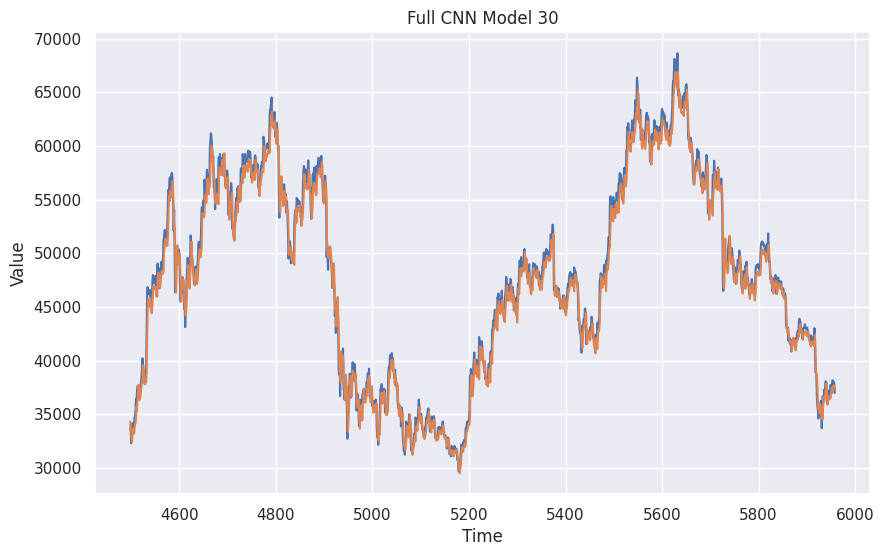

In [ ]:
# Plot results
plt.figure(figsize=(10, 6))

plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title(f'Full CNN Model {window_size}')
plot_series(x_test.index, x_test)
plot_series(x_test.index, cnn_unscaled_forecast)

In [ ]:
# Calculate MAE
keras.metrics.mean_absolute_error(x_test, cnn_unscaled_forecast).numpy()

910.68243